# Capture historic polling data from Wikipedia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Output-location" data-toc-modified-id="Output-location-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Output location</a></span></li><li><span><a href="#Raw-data-capture" data-toc-modified-id="Raw-data-capture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Raw data capture</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Compile-a-table-of-opinion-polls" data-toc-modified-id="Compile-a-table-of-opinion-polls-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compile a table of opinion polls</a></span></li><li><span><a href="#Quick-look-at-2019-herding" data-toc-modified-id="Quick-look-at-2019-herding-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Quick look at 2019 herding</a></span></li><li><span><a href="#Save" data-toc-modified-id="Save-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import pandas as pd
import matplotlib.pyplot as plt

# system imports
import pathlib

# local imports
import common

## Output location

In [2]:
DATA_DIR = '../historical-data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

## Raw data capture

In [3]:
links = {
    # election-date: [url, table-number],
    '2019-05-18': ['https://en.wikipedia.org/wiki/'
                   'Opinion_polling_for_the_2019_Australian_federal_election',
                   1],
    '2016-07-02': ['https://en.wikipedia.org/wiki/'
                   'National_opinion_polling_for_the_2016_Australian_federal_election',
                   2],
    '2013-09-07': ['https://en.wikipedia.org/wiki/'
                   'Opinion_polling_for_the_2013_Australian_federal_election',
                   1],
    
    # This is only Newspoll polling data ... also oddly formatted
    #'2010-08-21': ['https://en.wikipedia.org/wiki/'
    #               'Opinion_polling_for_the_2010_Australian_federal_election',
    #               0],
    
    # Earlier polling data does not appear to be available on Wikipedia
}

In [4]:
def capture_raw_tables(links):
    raw_tables = {}
    for elect_date, (url, number) in links.items():
        text = common.get_url_text(url)
        table = common.get_table_from_text(number, text)
        raw_tables[elect_date] = table
    return raw_tables

raw_tables = capture_raw_tables(links)

In [5]:
if False: # display tables
    for elect_date, table in raw_tables.items():
        print(elect_date)
        display(table)

In [6]:
raw_tables['2019-05-18']

Date                          Firm Primary vote          \
       Unnamed: 0_level_1            Unnamed: 1_level_1         L/NP     ALP   
0    18 May 2019 election                           NaN       41.44%  33.34%   
1             18 May 2019  YouGov-Galaxy (Exit Poll)[1]          39%     38%   
2          15–16 May 2019                   Newspoll[2]          38%     37%   
3          13–15 May 2019              YouGov-Galaxy[3]          39%     37%   
4          12–15 May 2019                      Ipsos[4]          39%     33%   
..                    ...                           ...          ...     ...   
199   28 Jun – 1 Jul 2016                 Newspoll[192]          42%     35%   
200           30 Jun 2016                 ReachTEL[193]        42.8%   34.6%   
201        27–30 Jun 2016                Essential[194]        42.5%   34.5%   
202        28–29 Jun 2016                   Galaxy[195]          43%     36%   
203        26–29 Jun 2016                    Ipsos[196]          40%     33%   

                          TPP vote          
       GRN    ONP     OTH     L/NP     ALP  
0    10.4%  3.08%  11.74%   51.53%  48.47%  
1      10%    NaN     10%      48%     52%  
2       9%     3%  13%[a]    48.5%   51.5%  
3       9%     3%  12%[b]      49%     51%  
4      13%     4%  11%[c]      49%     51%  
..     ...    ...     ...      ...     ...  
199    10%    NaN     13%    50.5%   49.5%  
200  10.7%    NaN     12%      51%     49%  
201  11.5%    NaN     12%    50.5%   49.5%  
202    10%    NaN     11%      51%     49%  
203    13%    NaN     14%      50%     50%  

[204 rows x 9 columns]

## Data cleaning

In [7]:
clean_tables = {}
for election_date, table in raw_tables.items():
    clean_tables[election_date] = common.clean(table)

## Compile a table of opinion polls 

using data for the period 3 months prior to a Federal election

In [8]:
def compile_table(clean_tables):

    RELEVANT_PERIOD = 100 # DAYS
    keep_cols = ['Date', 'Firm', 'Primary vote L/NP', 
                 'Primary vote ALP',
                 'Primary vote GRN', 'Primary vote ONP', 
                 'Primary vote OTH',
                 '2PP vote L/NP', '2PP vote ALP', 'Sample size']

    final_table = None
    for election, table in clean_tables.items():
    
        # standardise column names
        table = table.copy().rename(columns={'TPP vote': '2PP vote'}, level=0)
        table = table.rename(columns={'L/NP*': 'L/NP'}, level=1)
        table = table.rename(columns={'Labor': 'ALP'}, level=1)
        table = table.rename(columns={'Green': 'GRN'}, level=1)
        table = table.rename(columns={'Other': 'OTH'}, level=1)
        table.columns = common.flatten_col_names(table.columns)
    
        # select most recent rows
        keep = pd.Timestamp(election) - pd.Timedelta(days=RELEVANT_PERIOD)
        table = table[table.index >= keep]
        keepers = [x for x in keep_cols if x in table.columns]
        table = table[keepers]
        table['Election'] = election
    
        # merge into a single table we will save ...
        final_table = (
            # There must be an easier way of doing this ... 
            table if final_table is None 
            else final_table.T.merge(table.T, how='outer', 
                                     left_index=True, 
                                     right_index=True).T
        )
        
    return final_table


final_table = compile_table(clean_tables)

## Quick look at 2019 herding

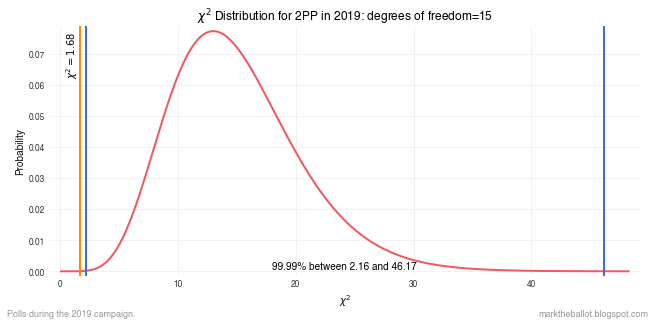

In [9]:
plt.style.use('./markgraph.mplstyle')

PERCENT = 99.99

sample_sizes = (
    pd.Series([3008, 1000, 1842, 1201, 1265, 1644, 1079, 826, 
        2003, 1207, 1000, 826, 2136, 1012, 707, 1697]))
measurements = ( # for Labor:
    pd.Series([51.5, 51,   51,   51.5, 52,   51,   52,   51,  
        51,   52,   51,   51,  51,   52,   51,  52]))

X, X_min, X_max, dof, _ = common.calc_chi_squared(measurements, 
                                      sample_sizes=sample_sizes, 
                                      percent=PERCENT)

fig, ax = common.plot_chi_square(X, X_min, X_max, dof, percent=PERCENT)
title = f'$\chi^2$ Distribution for 2PP in 2019: degrees of freedom={str(dof)} '
common.plot_finalise(ax, title=title, xlabel='$\chi^2$', ylabel='Probability',
                         lfooter=f'Polls during the 2019 campaign. ')

## Save

In [10]:
final_table.to_excel(DATA_DIR+'historical-poll-data.xlsx')